In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools

In [119]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                x_Y = 0.5 + U 
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [3]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [4]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    columns = ["time", "gamma_0", "gamma_1", "gamma_2", "gamma_3", "gamma_4", \
              "gamma_5", "gamma_6"]
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model_df = pd.DataFrame(columns = columns)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "A_1"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + \
                         [L1_model.params[i] for i in range(0,2)] + ["Nan"] + \
                         ["Nan"] + [L1_model.params[2]] + ["Nan"] + ["Nan"], \
                         index = columns).transpose(), ignore_index=True)
        elif ii == 2: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] \
                          for i in range(0,3)] + ["Nan"] + [L1_model.params[i] for i \
                          in range(3,5)] + ["Nan"], index = columns).transpose(), \
                          ignore_index=True)
        else: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] for \
                          i in range(0,7)], index = columns).transpose(), \
                          ignore_index=True)
    return(L1_model_df)

In [196]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    columns = ["time", "zeta_0", "zeta_1", "zeta_2", "zeta_3", "zeta_4"]
    train_columns = ["L1", "L1_1", "A_1", "A_2"]
    A_model_df = pd.DataFrame(columns = columns)

    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,2)] + [float("nan")] + [float("nan")] +[float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        elif ii == 1: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "A_1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,4)] + [float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        else: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[train_columns]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,5)],index = columns).transpose(), \
                         ignore_index=True)
    return(A_model_df)


In [379]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    values[1] = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    p_v = np.exp(values[1])/(1+np.exp(values[1]))
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    values[2] = np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = (np.exp(values[2])/(1+np.exp(values[2]))) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        values[jj] = np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = (np.exp(values[jj])/(1+np.exp(values[jj]))) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [709]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [619]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [559]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [631]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [713]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [562]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_dr_bin_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference", \
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

results_dr_bin_int_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference", \
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

results_g_form_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]

    # df = df.iloc[:,0:12]
    alpha_model = alpha_model_creation(df,False)
    [treatdr1_bin, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model, False)
    results_dr_bin_df.loc[len(results_dr_bin_df)+1] = [treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 

    [treatdr1_bin, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model, True)
    [treatdr0_bin, values0] = DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model, True)
    results_dr_bin_int_df.loc[len(results_dr_bin_int_df)+1] = [treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 

    
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.559310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617325


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ValueError: shapes (1000,5) and (6,) not aligned: 5 (dim 1) != 6 (dim 0)

In [564]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [833]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(results_good))
print(np.nanmean(results_sbad))
print(np.nanmean(results_alphabad))
print(np.nanmean(results_bothbad))
print(np.mean(results_good)-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.00607743957264
0.010967600767
0.01183136253
0.0478152075693
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [762]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)


In [817]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 100

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, len(s_model_wrong_no)): 
        
        for kk in range(0,max_time+1):
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no[jj][kk])
            alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no[jj], s_model_wrong_no[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no[jj], s_model_wrong_no[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df.loc[len(dr_test_df)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413726
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398586
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399362
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400918
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403865
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412689
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410825
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410751
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406464
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410805
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414435
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408899
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383017
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406549
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413541
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414556
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407282
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409632
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418412
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402104
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402050
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410486
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

25
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

26
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406066
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

27
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422048
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

28
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401487
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

29
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408653
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

30
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404540
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

31
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

32
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408268
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

33
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

34
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411762
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

35
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

36
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417214
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

37
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401871
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

38
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399610
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

39
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412031
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

40
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

41
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402670
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

42
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400062
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

43
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421336
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

44
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418967
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

45
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404785
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

46
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406888
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

47
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415302
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

48
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398015
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

49
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402519
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

50
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409174
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

51
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412704
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

52
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412846
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

53
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415073
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

54
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408508
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

55
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408213
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

56
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409753
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

57
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398769
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

58
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404074
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

59
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425171
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

60
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415528
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

61
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404469
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

62
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406536
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

63
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405355
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

64
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395952
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

65
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411502
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

66
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405903
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

67
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418215
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

68
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413832
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

69
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398221
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

70
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408944
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

71
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

72
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405892
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

73
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409057
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

74
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406914
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

75
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409500
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

76
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412829
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

77
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398173
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

78
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402071
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

79
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410951
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

80
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408119
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

81
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418237
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

82
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411503
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

83
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

84
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404154
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

85
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418206
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

86
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417840
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

87
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409367
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

88
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403304
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

89
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401276
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

90
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408906
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

91
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405933
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

92
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412240
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

93
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408881
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

94
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403128
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

95
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422053
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

96
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390930
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

97
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404961
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

98
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418169
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

99
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407101
  

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [823]:
dr_test_df.to_csv("Multiple_Robust_Test100")

In [819]:
data1 = go.Scatter(
        y= dr_test_df.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [822]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [820]:
dr_test_df.groupby(["expect", "which_mod"])["difference"].var()

expect  which_mod
no      0.0          0.001272
        1.0          0.001007
        2.0          0.000975
        3.0          0.000928
        4.0          0.000924
        5.0          0.000930
        6.0          0.000926
        7.0          0.000968
        8.0          0.001064
        9.0          0.088113
yes     0.0          0.001272
        1.0          0.001284
        2.0          0.001319
        3.0          0.001456
        4.0          0.012881
        5.0          0.019488
        6.0          0.020595
        7.0          0.009951
        8.0          0.021423
        9.0          0.088113
Name: difference, dtype: float64

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [834]:
trace1 = go.Box(
    y=results_good, 
    name = "Both Correct"
)
trace2 = go.Box(
    y=results_sbad, 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=results_alphabad, 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=results_bothbad, 
    name = "Both Mispsecified"
)
data = [trace1, trace2, trace3, trace4]
py.iplot(data, filename='boxplot')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [310]:
## TESTING NATURAL COUSE 
def natural_course_test(df, reps): 
    max_time = 11
    indiv = 1000
    results_df = pd.DataFrame(columns = list(df))
    for jj in range(0, reps): 
        # df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
        Y_model = Y_model_creation(df, max_time)
        L1_model_df = covariate_model_creation(df, max_time)
        A_model_df = treatment_model_creation(df, max_time)
    
        new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
        for ii in range(0, max_time+1): 
            if ii == 0: 
                L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

                p_A = np.sum(np.array([A_model_df.ix[0,][i] for i in [1,2]])*np.transpose(\
                     np.array([[1.0]*indiv,L0])), axis = 1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A0))

                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 1: 
                p_L = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                    np.array([[1.0]*indiv,new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[1,][i] for i in [1,2,3,4]])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis =1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 2: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in [1,2,3,5,6]])*
                         np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                         new_df[new_df["time"] == ii-2].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))


                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            else: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in range(1,8)])\
                         *np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                         new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                         new_df[new_df["time"] == ii-3].A])), axis = 1)


                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

        for kk in range(1,max_time+1):
            new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
            new_df["A_"+str(kk)] = new_df.A.shift(kk)

        small_df = new_df[new_df["time"] == 11.0]
        cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
        small_df = small_df[cols]
        p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
        small_df.Y = np.random.binomial(n=1, p = sp.special.expit(p_Y))
        results_df.loc[jj] = np.mean(small_df)
    return(results_df)

In [322]:
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
print(np.mean(df))

A          0.847667
L1         0.833000
U          0.547994
Y          0.714000
indiv    500.500000
time       5.500000
L1_1       0.833069
A_1        0.847654
L1_2       0.833056
A_2        0.847641
L1_3       0.833042
A_3        0.847629
L1_4       0.833028
A_4        0.847616
L1_5       0.833014
A_5        0.847603
L1_6       0.833000
A_6        0.847590
L1_7       0.832986
A_7        0.847578
L1_8       0.832972
A_8        0.847648
L1_9       0.832958
A_9        0.847636
L1_10      0.832944
A_10       0.847706
L1_11      0.832930
A_11       0.847777
dtype: float64


In [324]:
x = natural_course_test(df, 5)
np.mean(x)

Optimization terminated successfully.
         Current function value: 0.583654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441015
  

A          0.8468
L1         0.8112
U             NaN
Y          0.7188
indiv    499.5000
time      11.0000
L1_1       0.8114
A_1        0.8470
L1_2       0.8116
A_2        0.8470
L1_3       0.8118
A_3        0.8470
L1_4       0.8114
A_4        0.8472
L1_5       0.8110
A_5        0.8472
L1_6       0.8114
A_6        0.8470
L1_7       0.8116
A_7        0.8472
L1_8       0.8120
A_8        0.8474
L1_9       0.8120
A_9        0.8472
L1_10      0.8124
A_10       0.8470
L1_11      0.8128
A_11       0.8470
dtype: float64

In [328]:
np.mean(x)-1.96*np.sqrt(np.var(x)/5)

A          0.839889
L1         0.792869
U               NaN
Y          0.704804
indiv    499.500000
time      11.000000
L1_1       0.793354
A_1        0.840098
L1_2       0.793427
A_2        0.840324
L1_3       0.793910
A_3        0.840233
L1_4       0.793483
A_4        0.840424
L1_5       0.792672
A_5        0.840424
L1_6       0.792760
A_6        0.840852
L1_7       0.792779
A_7        0.841349
L1_8       0.793176
A_8        0.841312
L1_9       0.793119
A_9        0.841349
L1_10      0.793925
A_10       0.841239
L1_11      0.794368
A_11       0.840927
dtype: float64

In [329]:
np.mean(x)+1.96*np.sqrt(np.var(x)/5)

A          0.853711
L1         0.829531
U               NaN
Y          0.732796
indiv    499.500000
time      11.000000
L1_1       0.829446
A_1        0.853902
L1_2       0.829773
A_2        0.853676
L1_3       0.829690
A_3        0.853767
L1_4       0.829317
A_4        0.853976
L1_5       0.829328
A_5        0.853976
L1_6       0.830040
A_6        0.853148
L1_7       0.830421
A_7        0.853051
L1_8       0.830824
A_8        0.853488
L1_9       0.830881
A_9        0.853051
L1_10      0.830875
A_10       0.852761
L1_11      0.831232
A_11       0.853073
dtype: float64

In [134]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

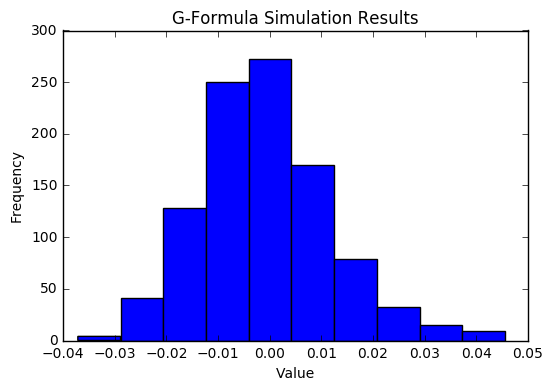

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

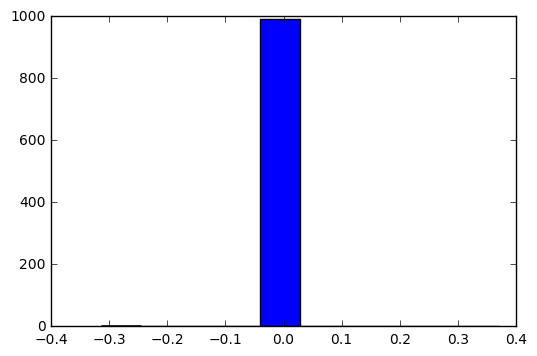

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer', api_key='Jfc79CurOmlfLyFufhnP')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [423]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

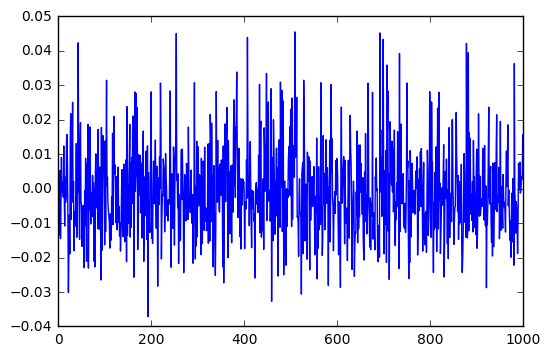

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

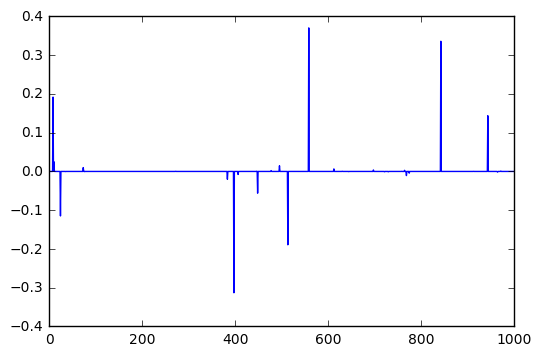

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001